## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [160]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload
from skimage import io
from itertools import chain
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import precision_score, roc_auc_score, recall_score, f1_score,classification_report,confusion_matrix
import tensorflow as tf
import keras as K
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam,RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext autoreload
%autoreload
from student_utils import clean_input_csv,conv_finds_to_binary_cols

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = clean_input_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['image_index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,image_index,finding_labels,follow_up,patient_id,patient_age,patient_gender,view_position,image_width,image_height,image_pixel_spacing_x,image_pixel_spacing_y,path
55866,00013977_001.png,Nodule,1,13977,56,M,AP,2500,2048,0.168,0.168,/data/images_007/images/00013977_001.png
67987,00016789_012.png,Infiltration,12,16789,35,M,PA,2478,2765,0.143,0.143,/data/images_008/images/00016789_012.png
60298,00014888_004.png,No Finding,4,14888,43,M,AP,2500,2048,0.168,0.168,/data/images_007/images/00014888_004.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
xrays_fin_cols_df=conv_finds_to_binary_cols(all_xray_df)
xrays_fin_cols_df.head(5)

,image_index,finding_labels,follow_up,patient_id,patient_age,patient_gender,view_position,image_width,image_height,image_pixel_spacing_x,image_pixel_spacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,0.143,/data/images_001/images/00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,0.171,/data/images_001/images/00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,0.143,/data/images_001/images/00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
#pneumonia_df=pd.DataFrame(columns=["pneumonia_class"])
#pneumonia_df["pneumonia_class"]=(xrays_fin_cols_df["Pneumonia"]==1).astype(int)
xrays_fin_cols_df["pneumonia_class"]=(xrays_fin_cols_df["Pneumonia"]==1).astype(int)
# Todo

In [6]:
xrays_fin_cols_df.keys()

Index(['image_index', 'finding_labels', 'follow_up', 'patient_id',
       'patient_age', 'patient_gender', 'view_position', 'image_width',
       'image_height', 'image_pixel_spacing_x', 'image_pixel_spacing_y',
       'path', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax', 'pneumonia_class'],
      dtype='object')

In [7]:
#print the unique values count in each finding
xrays_fin_cols_df[xrays_fin_cols_df.keys()[-16:]].agg(lambda x:x.value_counts())

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,100561,109344,107453,109817,98803,109604,110434,111893,92226,106338,51759,105789,108735,110689,106818,110689
1,11559,2776,4667,2303,13317,2516,1686,227,19894,5782,60361,6331,3385,1431,5302,1431


In [8]:
print(xrays_fin_cols_df["pneumonia_class"].sum()/len(xrays_fin_cols_df))


0.012763110952550838


## Create your training and testing data:

In [9]:
def create_splits(x_df):
    df=x_df.copy()
    group_list=["patient_id"]
    agg_list=["pneumonia_class"]

    grouped_df=df.groupby(group_list)[agg_list].agg(lambda x: 
                                                            list([y for y in x] ) ).reset_index()
    grouped_df["pneumonia_class"]=grouped_df["pneumonia_class"].agg(lambda x:1 if 1 in x else 0)
    #print(grouped_df.head())
    train_patients_df,valid_patients_df=skl.train_test_split(grouped_df,test_size = 0.2,
                                                             stratify=grouped_df["pneumonia_class"])
    train_patients=train_patients_df["patient_id"].unique()
    valid_patients=valid_patients_df["patient_id"].unique()
    # print(len(train_patients))
    # print(len(valid_patients))
    train_df=df[ df["patient_id"].isin( train_patients)]
    train_df=train_df.reset_index(drop=True)
    valid_dataset_df=df[ df["patient_id"].isin( valid_patients)]
    valid_dataset_df=valid_dataset_df.reset_index(drop=True)
    
    p_valid_df=valid_dataset_df[valid_dataset_df["pneumonia_class"]==1]
    n_valid_df=valid_dataset_df[valid_dataset_df["pneumonia_class"]==0].sample(3*len(p_valid_df),axis=0, random_state=1)
    val_dataset_df=pd.concat([p_valid_df,n_valid_df],axis=0)
    val_dataset_df=val_dataset_df.reset_index(drop=True)
    val_dataset_df=val_dataset_df.sample(frac=1,axis=0,random_state=4)
    val_dataset_df=val_dataset_df.reset_index(drop=True)


    p_train_df=train_df[train_df["pneumonia_class"]==1]
    n_train_df=train_df[train_df["pneumonia_class"]==0].sample(len(p_train_df),axis=0, random_state=1)
    tr_dataset_df=pd.concat([p_train_df,n_train_df],axis=0)#
    tr_dataset_df=tr_dataset_df.reset_index(drop=True)

    tr_dataset_df=tr_dataset_df.sample(frac=1,axis=0,random_state=4)
    tr_dataset_df=tr_dataset_df.reset_index(drop=True)
    return(tr_dataset_df,val_dataset_df)

In [10]:
tr_set_df,valid_set_df=create_splits(xrays_fin_cols_df)

In [11]:
valid_set_df.head()

,image_index,finding_labels,follow_up,patient_id,patient_age,patient_gender,view_position,image_width,image_height,image_pixel_spacing_x,image_pixel_spacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00016434_001.png,"[Effusion, Nodule, Pneumonia]",1,16434,61,M,PA,2992,2991,0.143,0.143,/data/images_008/images/00016434_001.png,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1
1,00003426_026.png,[No Finding],26,3426,60,M,AP,2500,2048,0.168,0.168,/data/images_002/images/00003426_026.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,00006008_005.png,"[Effusion, Pneumonia]",5,6008,72,M,PA,2992,2991,0.143,0.143,/data/images_003/images/00006008_005.png,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,00016410_044.png,[No Finding],44,16410,42,F,AP,2500,2048,0.168,0.168,/data/images_008/images/00016410_044.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,00029866_019.png,[Infiltration],19,29866,57,F,PA,2544,3056,0.139,0.139,/data/images_012/images/00029866_019.png,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [12]:
#valid_set_df[valid_set_df["patient_id"]==9736].head(10)


In [13]:
#xrays_fin_cols_df[xrays_fin_cols_df["patient_id"]==9736].tail(10)

In [14]:
#explore the percentige of each findings in both  datasets
print(tr_set_df["pneumonia_class"].sum()/len(tr_set_df))
print(valid_set_df["pneumonia_class"].sum()/len(valid_set_df))

0.5
0.25


In [15]:
#valid_dataset_df.isnull().sum()
#tr_set_df.info()

In [16]:
df_test=pd.DataFrame()
df_test["test"]=tr_set_df["pneumonia_class"].astype(str)

In [17]:
#df_test.info()
#df_test["test"].values

In [18]:
print(tr_set_df[tr_set_df.keys()[-16:]].sum()/len(tr_set_df))
print(valid_set_df[valid_set_df.keys()[-16:]].sum()/len(valid_set_df))

Atelectasis           0.143421
Cardiomegaly          0.028070
Consolidation         0.061842
Edema                 0.130263
Effusion              0.160965
Emphysema             0.023684
Fibrosis              0.011842
Hernia                0.001754
Infiltration          0.296930
Mass                  0.059649
No Finding            0.263596
Nodule                0.058333
Pleural_Thickening    0.037719
Pneumonia             0.500000
Pneumothorax          0.042982
pneumonia_class       0.500000
dtype: float64
Atelectasis           0.115120
Cardiomegaly          0.013746
Consolidation         0.054983
Edema                 0.068729
Effusion              0.118557
Emphysema             0.018041
Fibrosis              0.014605
Hernia                0.001718
Infiltration          0.236254
Mass                  0.042096
No Finding            0.428694
Nodule                0.048110
Pleural_Thickening    0.019759
Pneumonia             0.250000
Pneumothorax          0.035223
pneumonia_class       0.

In [19]:
pathts=tr_set_df["path"].values[:12]
#tr_dataset_df["pneumonia_class"]=tr_dataset_df["pneumonia_class"].astype(str)

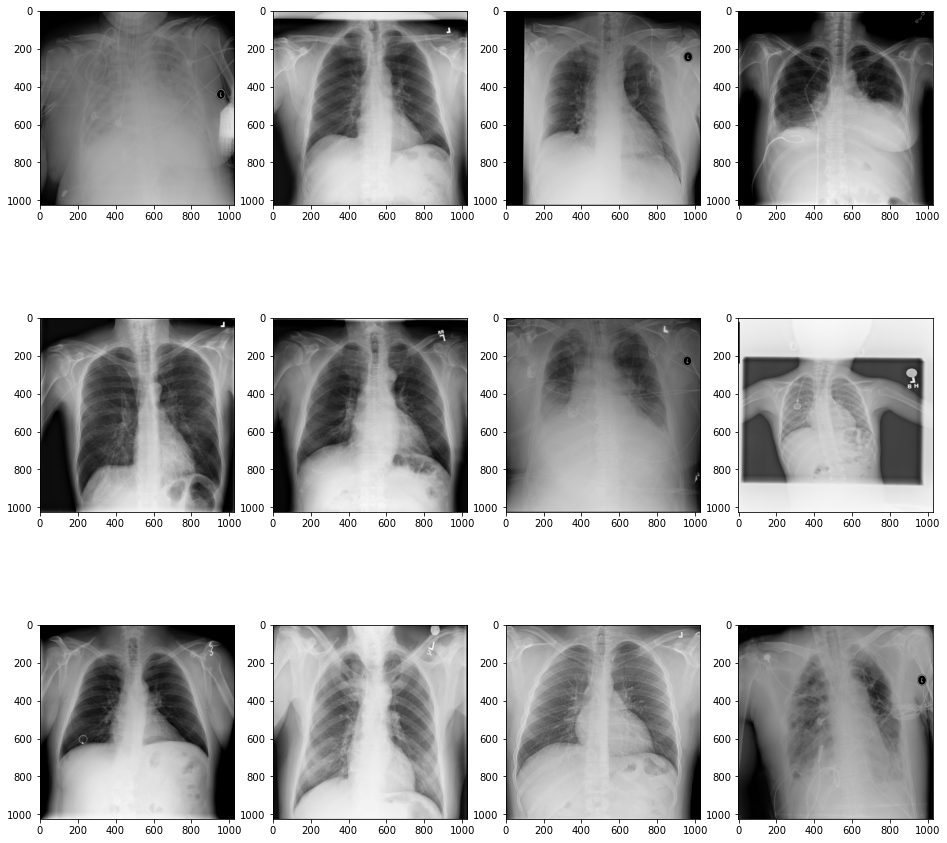

In [20]:
fig, m_axs = plt.subplots(3,4, figsize = (16, 16))
m_axs = m_axs.flatten()
ind=0

for img, ax in zip(pathts, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    #ax.set_title(df.iloc[ind]['class'])
    ind=ind+1
#print(img.shape)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [21]:
def my_image_augmentation():
       
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    tr_image_dg=ImageDataGenerator(rotation_range=10,
                                width_shift_range=0.04,
                                height_shift_range=0.04,
                                #brightness_range=[0.05,0.1],
                                shear_range=0.04,
                                zoom_range=0.04,
                                horizontal_flip=False,
                                vertical_flip=False, 
                                rescale=1./255.)
    return tr_image_dg

def make_train_gen(df):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    df=df.copy()
    df["pneumonia_class"]=df["pneumonia_class"].astype(str)
    tr_dg=my_image_augmentation()
    
    train_gen = tr_dg.flow_from_dataframe(dataframe=df, 
                                     directory=None, 
                                     x_col ='path' ,
                                     y_col ='pneumonia_class' ,
                                     class_mode = 'binary',
                                     target_size =(224,224) , 
                                     batch_size = 128,
                                     )

    return train_gen

def val_image_augmentation():
    val_image_dg=ImageDataGenerator(
                                rescale=1./255)
    return val_image_dg

def make_val_gen(df):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    df=df.copy()
    
    df["pneumonia_class"]=df["pneumonia_class"].astype(str)
    
    val_gen=val_image_augmentation()
    
    train_gen = val_gen.flow_from_dataframe(dataframe=df, 
                                     directory=None, 
                                     x_col ='path' ,
                                     y_col ='pneumonia_class' ,
                                     class_mode = 'binary',
                                     target_size =(224,224) , 
                                     batch_size = 128,
                                     shuffle=False,
                                     )

    return train_gen

In [22]:
train_gen=make_train_gen(tr_set_df)
val_gen=make_val_gen(valid_set_df)

Found 2280 validated image filenames belonging to 2 classes.
Found 1164 validated image filenames belonging to 2 classes.


In [23]:
## May want to pull a single large batch of random validation data for testing after each epoch:


In [24]:
#valX[1]

In [25]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

# t_x, t_y = next(train_gen)
# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         c_ax.set_title('Pneumonia')
#     else:
#         c_ax.set_title('No Pneumonia')
#     c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [26]:
def load_pretrained_model(last_layer,startof_trainable):
    m_vgg = VGG16(include_top=True, weights='imagenet')
    #m_vgg = VGG16(include_top=False, weights='imagenet',input_shape=(224, 224,1))

    state=False
    for layer in m_vgg.layers:
        if(layer.name==startof_trainable):
            state=True
        layer.trainable=state
    transfer_layer=m_vgg.get_layer(last_layer)
    vgg_model=Model(inputs=m_vgg.input,
                      outputs=transfer_layer.output)
    
    return vgg_model


In [27]:
def build_my_model():
    vgg_modified=load_pretrained_model("block5_pool","block5_conv3")

    my_model = Sequential()
    my_model.add(vgg_modified)
    my_model.add(Flatten())
    my_model.add(Dense(64,activation="relu",kernel_regularizer=K.regularizers.l2(0.01)))
    my_model.add(BatchNormalization())
    #Dropout(0.1),
    my_model.add(Dense(64,activation="relu",kernel_regularizer=K.regularizers.l2(0.01)))
    my_model.add(BatchNormalization())
    my_model.add(Dense(16,activation="relu"))#,kernel_regularizer=K.regularizers.l2(0.4)))
    my_model.add(Dense(1,activation='sigmoid'))
    

    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    optimizer = RMSprop(learning_rate=0.05)
    loss = 'binary_crossentropy'
    m_auc = tf.keras.metrics.AUC(thresholds=[0.5,0.7,0.3,0.4,0.6])
    m_precision = tf.keras.metrics.Precision()
    #m_recall = tf.keras.metrics.Recall()
    #m_falsen = tf.keras.metrics.FalsePositives()
    #m_falsep = tf.keras.metrics.FalseNegatives()
    metrics = ['binary_accuracy',m_precision,m_auc]
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [28]:
model1=build_my_model()

In [30]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting




checkpoint = ModelCheckpoint(filepath="weights.{epoch:02d}.hdf5", 
                             save_best_only=True,
                             monitor= 'val_loss',
                             mode= 'min', 
                             verbose=1, 
                             save_weights_only = True)

# early = EarlyStopping(monitor= 'val_auc', 
#                       mode= 'max', 
#                       patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                              patience=12, min_lr=1e-4,verbose=1,
                             mode= 'min')

callbacks_list = [checkpoint,reduce_lr]

### Start training! 

In [31]:
# train your model

#Todo

history = model1.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs =60 , steps_per_epoch=4,
                          validation_steps=4,
                          callbacks = callbacks_list)

Epoch 1/60
4/4 [==============================] - 24s 6s/step - loss: 126.9727 - binary_accuracy: 0.5039 - precision: 0.4593 - auc: 0.4827 - val_loss: 41.5582 - val_binary_accuracy: 0.2402 - val_precision: 0.3488 - val_auc: 0.4103

Epoch 00001: val_loss improved from inf to 41.55819, saving model to weights.01.hdf5
Epoch 2/60
4/4 [==============================] - 14s 4s/step - loss: 17.8511 - binary_accuracy: 0.5254 - precision: 0.3398 - auc: 0.3931 - val_loss: 21.3206 - val_binary_accuracy: 0.7344 - val_precision: 0.3637 - val_auc: 0.4542

Epoch 00002: val_loss improved from 41.55819 to 21.32063, saving model to weights.02.hdf5
Epoch 3/60
4/4 [==============================] - 17s 4s/step - loss: 6.6216 - binary_accuracy: 0.5781 - precision: 0.3895 - auc: 0.4908 - val_loss: 7.0836 - val_binary_accuracy: 0.7601 - val_precision: 0.4083 - val_auc: 0.5180

Epoch 00003: val_loss improved from 21.32063 to 7.08355, saving model to weights.03.hdf5
Epoch 4/60
4/4 [============================

4/4 [==============================] - 13s 3s/step - loss: 5.7146 - binary_accuracy: 0.6133 - precision: 0.4470 - auc: 0.5826 - val_loss: 6.1617 - val_binary_accuracy: 0.7344 - val_precision: 0.4480 - val_auc: 0.5841

Epoch 00029: val_loss did not improve from 3.00625
Epoch 30/60
4/4 [==============================] - 14s 3s/step - loss: 5.0132 - binary_accuracy: 0.6055 - precision: 0.4497 - auc: 0.5851 - val_loss: 3.7959 - val_binary_accuracy: 0.2323 - val_precision: 0.4462 - val_auc: 0.5813

Epoch 00030: val_loss did not improve from 3.00625
Epoch 31/60
4/4 [==============================] - 14s 4s/step - loss: 3.4318 - binary_accuracy: 0.6107 - precision: 0.4462 - auc: 0.5805 - val_loss: 3.3809 - val_binary_accuracy: 0.6445 - val_precision: 0.4467 - val_auc: 0.5811

Epoch 00031: val_loss did not improve from 3.00625

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.007999999821186066.
Epoch 32/60
4/4 [==============================] - 15s 4s/step - loss: 2.8418 - binary_ac

4/4 [==============================] - 15s 4s/step - loss: 1.1333 - binary_accuracy: 0.6230 - precision: 0.4573 - auc: 0.5895 - val_loss: 2.6409 - val_binary_accuracy: 0.2656 - val_precision: 0.4556 - val_auc: 0.5878

Epoch 00057: val_loss did not improve from 1.02148

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0031999997794628144.
Epoch 58/60
4/4 [==============================] - 17s 4s/step - loss: 0.9488 - binary_accuracy: 0.6406 - precision: 0.4550 - auc: 0.5869 - val_loss: 2.4236 - val_binary_accuracy: 0.2399 - val_precision: 0.4537 - val_auc: 0.5855

Epoch 00058: val_loss did not improve from 1.02148
Epoch 59/60
4/4 [==============================] - 14s 3s/step - loss: 0.8510 - binary_accuracy: 0.6578 - precision: 0.4535 - auc: 0.5848 - val_loss: 2.1202 - val_binary_accuracy: 0.2656 - val_precision: 0.4519 - val_auc: 0.5831

Epoch 00059: val_loss did not improve from 1.02148
Epoch 60/60
4/4 [==============================] - 13s 3s/step - loss: 0.8099 - binary_a

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [168]:
# model1.save_weights("delivery_weights0517.h5")


In [169]:
# hist_df=pd.DataFrame({"loss":history.history["loss"],
#                       "val_loss":history.history["val_loss"],
#                      "binary_accuracy": history.history["binary_accuracy"],
#                      "val_binary_accuracy":history.history["val_binary_accuracy"],
#                     "auc": history.history["auc"],
#                      "val_auc":history.history["val_auc"],
#                     "precision": history.history["precision"],
#                      "val_precision":history.history["val_precision"]})
# hist_df.to_csv(r'delivery_history0517.csv', index = False)

### testing is done on 7 batches of validation dataset

In [32]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
res_col=[]
class_col=[]
#path="weights.20-1.22.hdf5"
#model1.load_weights(path)
for i in range(7):
    valX, valY = val_gen.next()
    probY = model1.predict(valX, verbose = True)
    class_col.extend(valY)
    res_col.extend(probY.flatten())

    


128/128 [==============================] - 1s 9ms/step


In [ ]:
#res_col

correctly identified =67 from 100
true,predicted


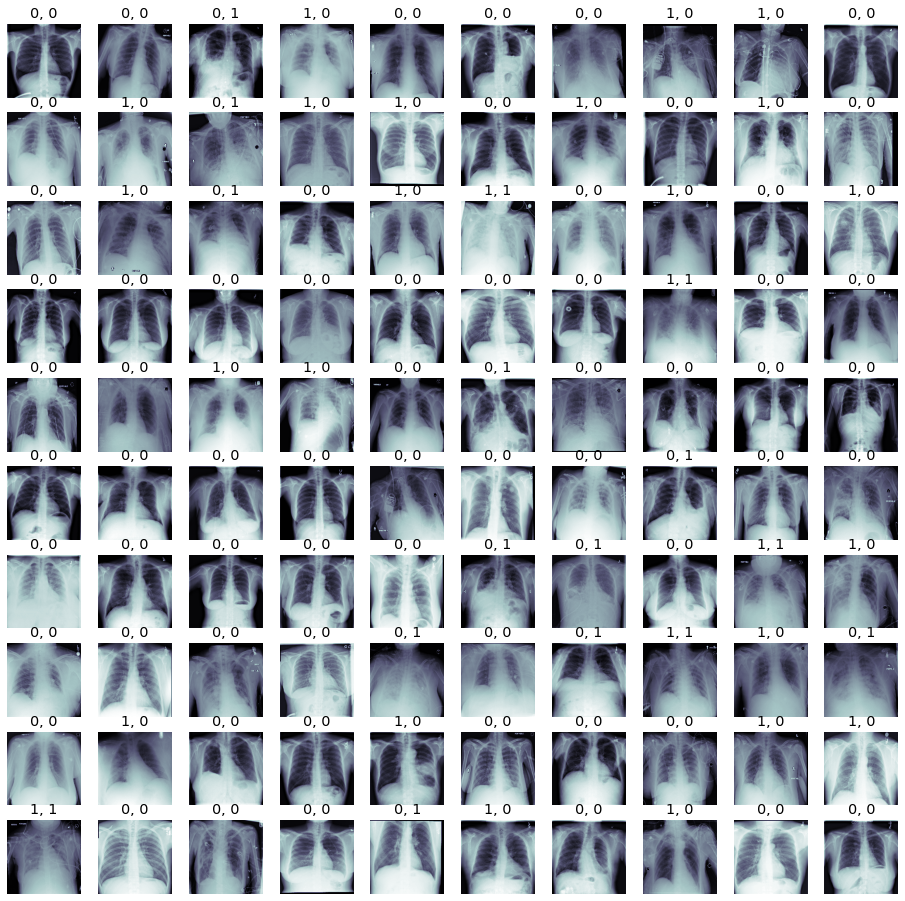

In [53]:
## Let's look at some examples of predicted v. true with our best model: 
THRESH=0.935
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
true_i=0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if probY[i] > THRESH:
            c_ax.set_title('1, 1')
            true_i+=1
        else:
            c_ax.set_title('1, 0')
    else:
        if probY[i] > THRESH: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
            true_i+=1
    c_ax.axis('off')
    i=i+1
print("correctly identified =%d from %d"%(true_i,i))
print("true,predicted")

## Performance Statistics
1- precision-recall curve    
2- roc curve    
3- precision, recall, auc, f1 score after threshold selection   
4- bias analysis ,algorithm limitation analysis   

In [165]:
def plot_auc(t_y, p_y):
    tpr,fpr,thresh=roc_curve(t_y.values, p_y.values)
    plt.figure(figsize=(14,6))
    plt.plot(tpr,fpr)
    ## YOUR CODE HERE
    ## Note you can utilize roc_curve and auc imported above
def plot_pr(t_y, p_y):
    pre,rec,thre=precision_recall_curve(y_true=t_y.values,probas_pred=p_y.values)
    plt.figure(figsize=(14,6))
    plt.plot(rec,pre)
    return (pre,rec,thre)

def calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)

#Also consider plotting the history of your model training:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history,start_from_epoch=0):
    st=start_from_epoch
    fig, m_axs = plt.subplots(4,1, figsize = (16, 16))
    m_axs = m_axs.flatten()
    N = len(history.history["loss"][st:])
    plt.style.use("ggplot")
    plt.figure(figsize=(14,6))
    m_axs[0].plot(np.arange(0, N), history.history["loss"][st:], label="train_loss")
    m_axs[0].plot(np.arange(0, N), history.history["val_loss"][st:], label="val_loss")
    m_axs[0].set_title('loss')
    m_axs[1].plot(np.arange(0, N), history.history["binary_accuracy"][st:], label="train_acc")
    m_axs[1].plot(np.arange(0, N), history.history["val_binary_accuracy"][st:], label="val_acc")
    m_axs[1].set_title('accuracy')
    m_axs[2].plot(np.arange(0, N), history.history["precision"][st:], label="train_pre")
    m_axs[2].plot(np.arange(0, N), history.history["val_precision"][st:], label="val_pre")
    m_axs[2].set_title('precision')
    m_axs[3].plot(np.arange(0, N), history.history["auc"][st:], label="train_rec")
    m_axs[3].plot(np.arange(0, N), history.history["val_auc"][st:], label="val_rec")
    m_axs[3].set_title('recall')

In [42]:
results=pd.DataFrame({"true_y":class_col,"prob_y":res_col})


In [43]:
results["prob_y"].sum()

832.6172353625298

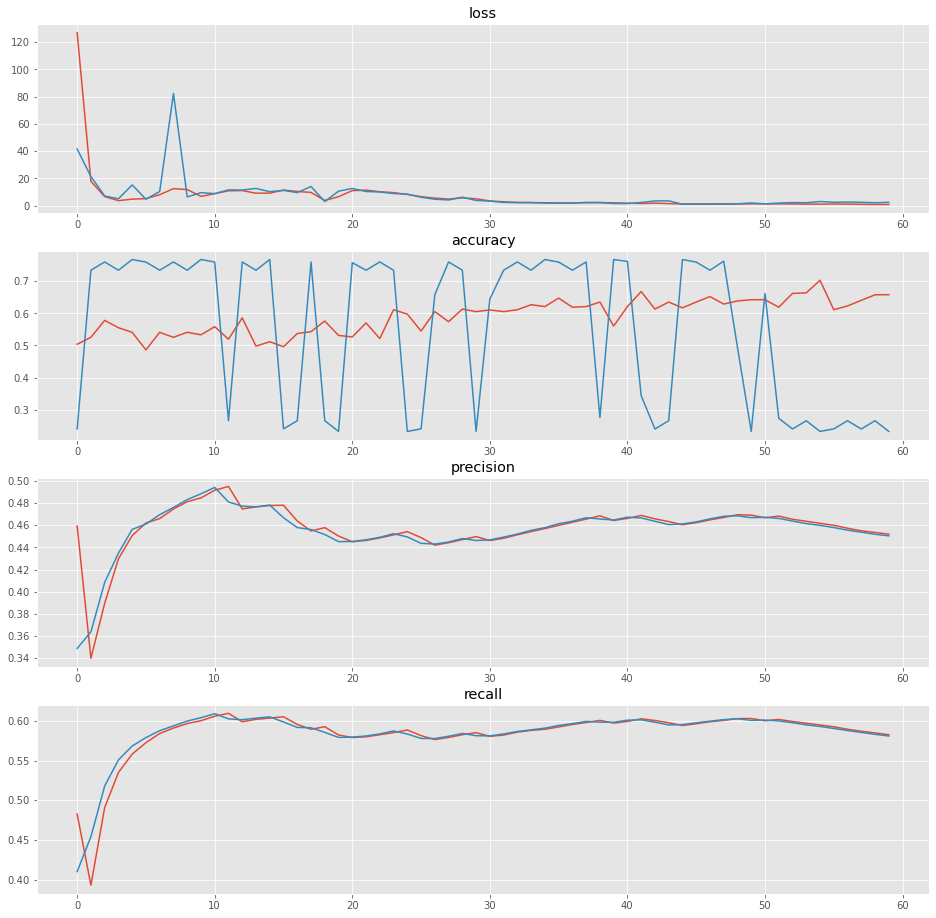

<Figure size 1008x432 with 0 Axes>

In [166]:
## plot figures
start_from_epoch=0
plot_history(history,start_from_epoch)
# Todo

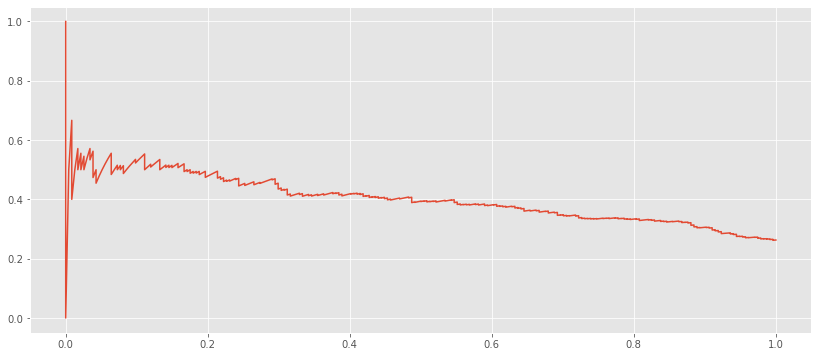

In [45]:
pre,rec,thr=plot_pr(results["true_y"],results["prob_y"])

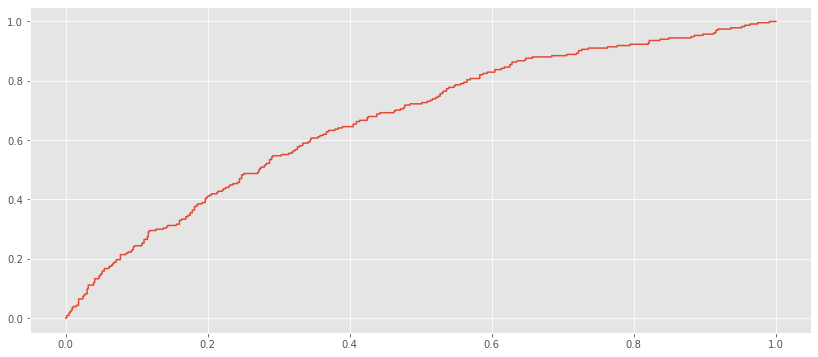

In [46]:
plot_auc(results["true_y"],results["prob_y"])


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [47]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
results["prob_y"].sum()

832.6172353625298

In [58]:
THRESH=0.935
results2=results.copy()
results2["pred"]=(results2["prob_y"]>THRESH).astype(int)
results2["true_y"]=results2["true_y"].astype(int)
#pred_Y=(prob_Y>THRESH).astype(int)

In [59]:
print(classification_report(results2["true_y"].values,results2["pred"].values))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       662
           1       0.45      0.26      0.33       234

    accuracy                           0.72       896
   macro avg       0.61      0.57      0.58       896
weighted avg       0.69      0.72      0.70       896



In [164]:
confusion_matrix(results2["true_y"].values, results2["pred"].values, labels=["1","0"],normalize='true')

array([[0.25641026, 0.74358974],
       [0.1102719 , 0.8897281 ]])

In [60]:
results2["pred"]=(results2["prob_y"]>THRESH).astype(int).astype(str)
results2["true_y"]=results2["true_y"].astype(int).astype(str)

In [61]:
## Just save model architecture to a .json:

model_json = model1.to_json()
with open("my_model_517.json", "w") as json_file:
    json_file.write(model_json)

In [62]:
#####Al
#results2.head()
test_df=valid_set_df[:len(results2)].copy()
test_df=pd.concat([test_df,results2],axis=1)
#test_df.head(50)

In [64]:
test_df=test_df.rename(columns={"pneumonia_class": "label_value", "pred": "score"})

In [65]:
test_df=test_df.drop("true_y",axis=1)
test_df=test_df.drop("prob_y",axis=1)

In [72]:
test_df["label_value"]=test_df["label_value"].astype(float)
test_df["score"]=test_df["score"].astype(float)
test_df[test_df.keys()[-17:-2]]=test_df[test_df.keys()[-17:-2]].astype(str)

In [155]:
label_g3=[]
label_g3.extend(list(test_df.keys()[-17:]))
label_g3.append("patient_gender")



In [156]:

from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness



In [157]:
ae_subset_df = test_df[label_g3]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)

absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

model_id, score_thresholds 1 {'rank_abs': [133]}


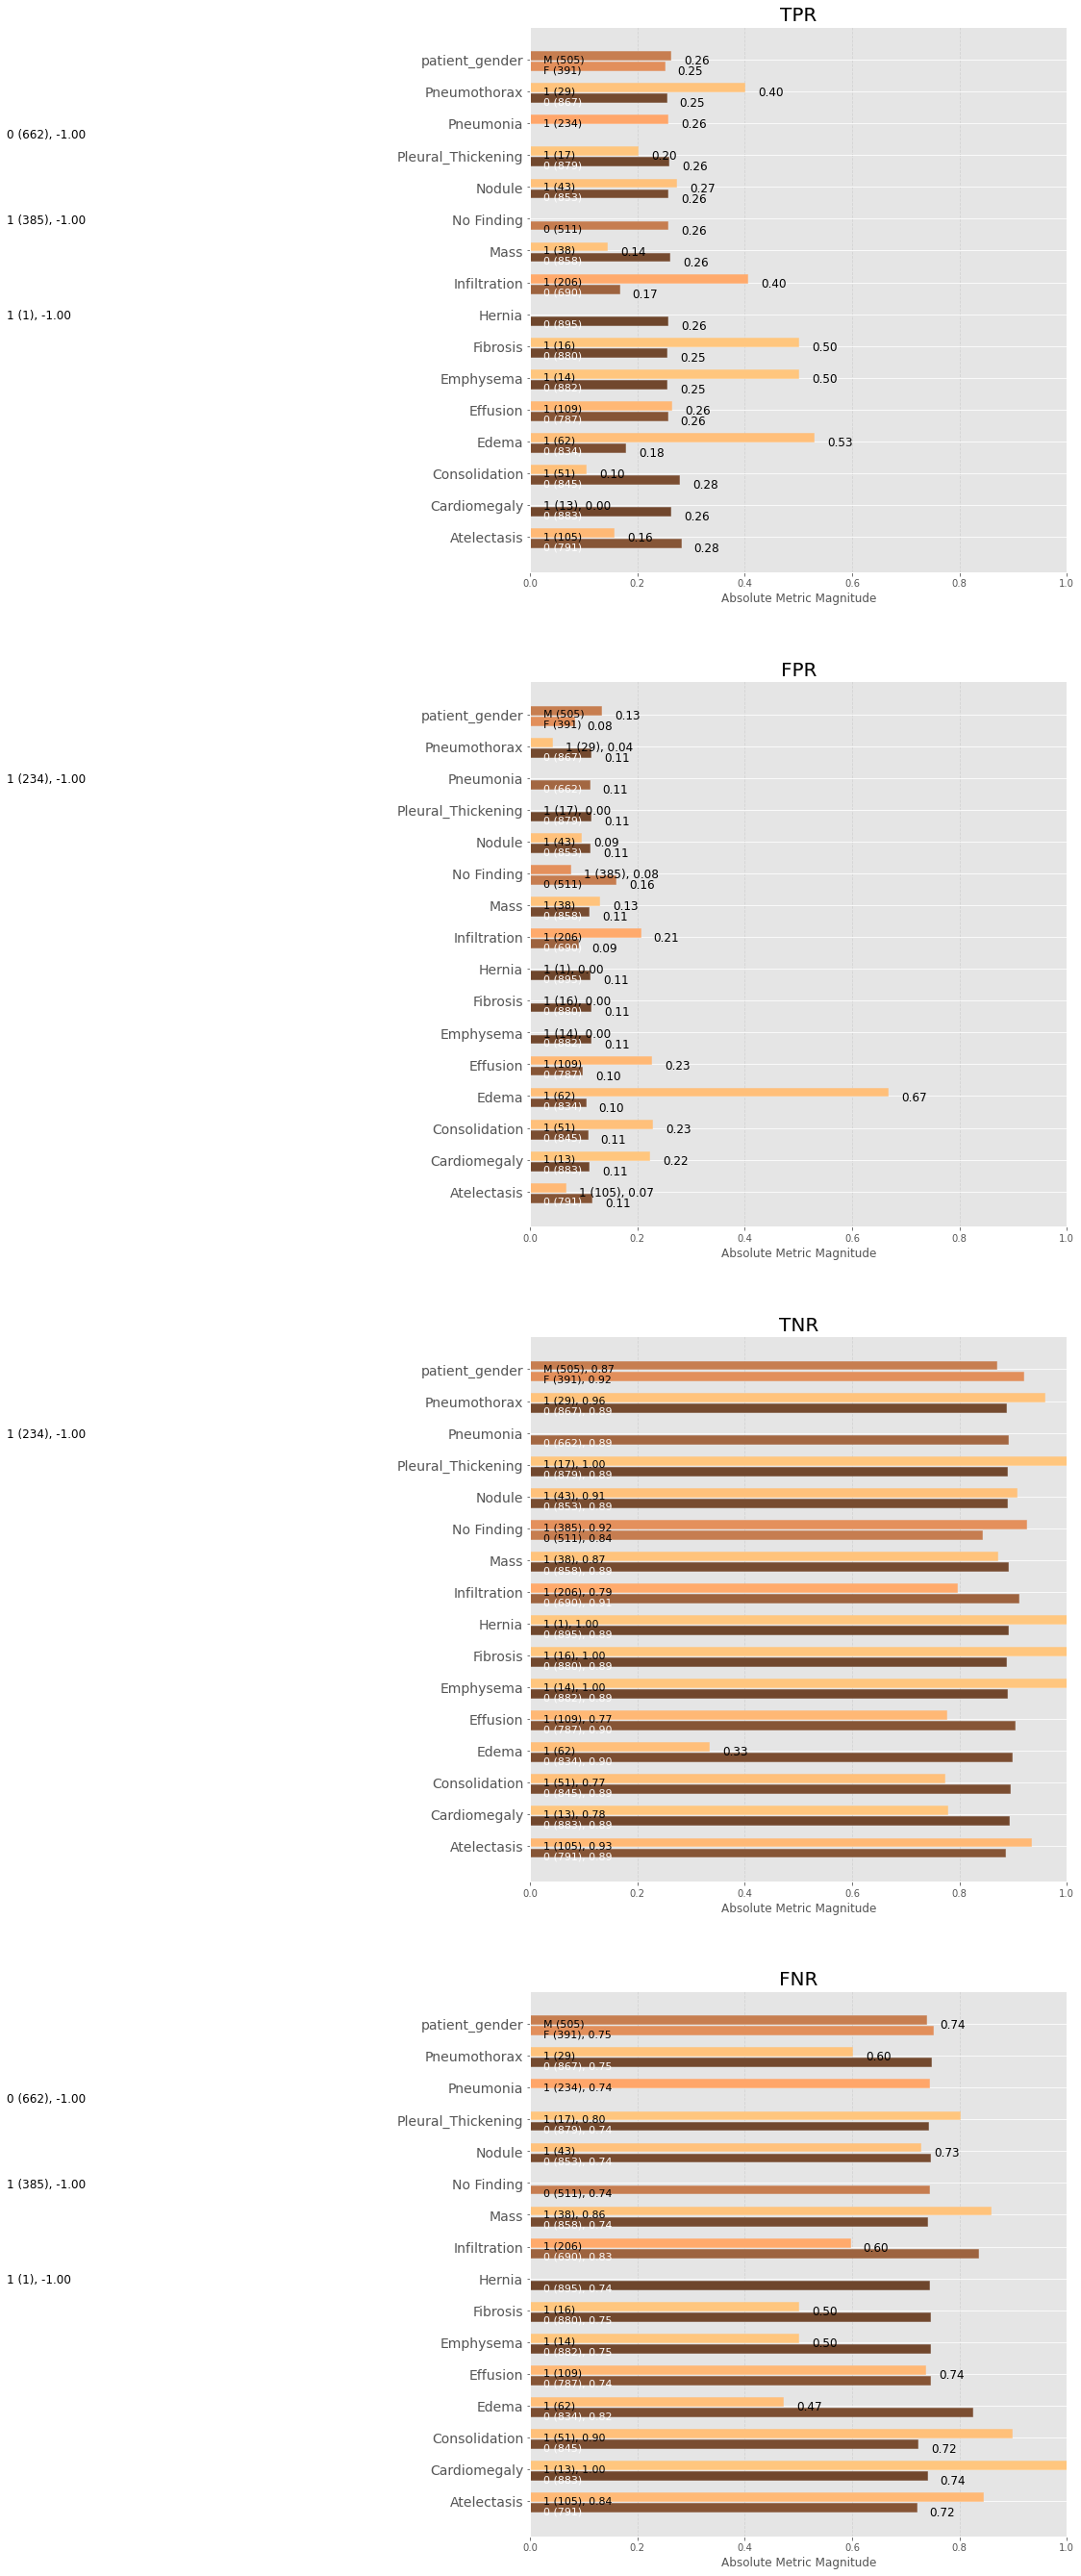

In [158]:
fig, m_axs = plt.subplots(4, 1, figsize = (10,48 ))
m_axs.flatten()
fpr_plot = aqp.plot_group_metric(clean_xtab, 'tpr',ax=m_axs[0])#,min_group_size=0.02)
fpr_plot = aqp.plot_group_metric(clean_xtab, 'fpr',ax=m_axs[1])
fpr_plot = aqp.plot_group_metric(clean_xtab, 'tnr',ax=m_axs[2])
fpr_plot = aqp.plot_group_metric(clean_xtab, 'fnr',ax=m_axs[3])